# Setup

In [1]:
%load_ext autoreload

In [21]:
%autoreload 2

import copy
import functools
import itertools
import logging
import re
import time
import yaml
from collections import Counter

import humanize
from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import scipy as sp
from numpy import ndarray
from matplotlib import pyplot as plt, patches, cm
from sklearn import metrics as met
from progressbar import progressbar as pbar
from tensorflow.keras import layers
from sklearn import metrics, preprocessing
from sklearn import model_selection
import skimage
from skimage import measure, io
import pandas as pd
import seaborn as sns

import tomo2seg.data as tomo2seg_data
from tomo2seg.data import ModelPaths, Volume, EstimationVolume, SetPartition
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz
from tomo2seg.logger import logger

In [3]:
from tomo2seg.data import VOLUME_PRECIPITATES_V1 as VOL_NAME_VERSION
logger.debug(f"{VOL_NAME_VERSION=}")

In [4]:
logger.setLevel(logging.DEBUG)

In [5]:
random_state = 42
random_state = np.random.RandomState(random_state)

# Load from the disk

In [6]:
# Metadata/paths objects

## Volume
volume = Volume.with_check(
    volume_name := VOL_NAME_VERSION[0], 
    volume_version := VOL_NAME_VERSION[1]
)
logger.info(f"{volume=}")

hst_read = lambda x: functools.partial(
    # from pymicro
    file_utils.HST_read,
    # pre-loaded kwargs
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
)(str(x))  # it doesn't accept paths...

blobs_path_prefix = str(volume.versioned_labels_path("original"))[:-4]
logger.debug(f"{blobs_path_prefix=}")

[2020-11-12::09:12:18.211] tomo2seg :: DEBUG :: {data.py:with_check:201}
vol=Volume(name='PA66GF30', version='v1', _metadata=None)

[2020-11-12::09:12:18.213] tomo2seg :: ERROR :: {data.py:with_check:219}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels.raw

[2020-11-12::09:12:18.215] tomo2seg :: WARNING :: {data.py:with_check:223}
Missing file: /home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.weights.raw

[2020-11-12::09:12:18.216] tomo2seg :: DEBUG :: {data.py:metadata:158}
Loading metadata from `/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.metadata.yml`.

[2020-11-12::09:12:18.223] tomo2seg :: INFO :: {<ipython-input-6-4fefebe63d9f>:<module>:008}
volume=Volume(name='PA66GF30', version='v1', _metadata=Volume.Metadata(dimensions=[1300, 1040, 1900], dtype='uint8', labels=[0, 1, 2], labels_names={0: 'matrix', 1: 'fiber', 2: 'porosity'}, set_partitions={'train': {'x_range': [0, 1299], 'y_range': [0

# Porosity blobs

## z-axis 2d blobs

**Note about the filenames here**

Search for (Ctrl + F) `[filenames]` in the script `compute_2d_blob_props.py` to see where they come from.

In [138]:
filename = f"{blobs_path_prefix}.porosity.z-blobs.csv"
logger.debug(f"{filename=}")

astype_map = {"area": int, "centroid-0": int, "centroid-1": int, "slice_idx": int}
rename_map = {"Unnamed: 0": "index", "centroid-0": "centroid-x", "centroid-1": "centroid-y", "slice_idx": "z"}
blobsdf = pd.read_csv(filename).astype(astype_map).rename(columns=rename_map).set_index("index")

logger.debug(f"{blobsdf.shape}")

blobsdf["aspect_ratio"] = blobsdf.major_axis_length / blobsdf.minor_axis_length

[2020-11-12::12:08:03.797] tomo2seg :: DEBUG :: {<ipython-input-138-902b0e275b61>:<module>:002}
filename='/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.labels-original.porosity.z-blobs.csv'

[2020-11-12::12:08:05.284] tomo2seg :: DEBUG :: {<ipython-input-138-902b0e275b61>:<module>:008}
(797696, 22)



In [139]:
blobsdf.head(10).T

index,0,1,2,3,4,5,6,7,8,9
label,2.0,2.0000,2.000000,2.00000,2.000000,2.00,2.000000,2.00,2.000000,2.000000
area,1.0,33.0000,21.000000,9.00000,5.000000,2.00,11.000000,4.00,22.000000,25.000000
bbox-0,0.0,0.0000,2.000000,2.00000,2.000000,4.00,9.000000,9.00,19.000000,26.000000
bbox-1,0.0,37.0000,496.000000,517.00000,854.000000,884.00,269.000000,458.00,96.000000,733.000000
bbox-2,1.0,4.0000,9.000000,6.00000,5.000000,6.00,13.000000,11.00,25.000000,30.000000
bbox-3,1.0,47.0000,502.000000,520.00000,857.000000,885.00,273.000000,460.00,108.000000,741.000000
bbox_area,1.0,40.0000,42.000000,12.00000,9.000000,2.00,16.000000,4.00,72.000000,32.000000
centroid-x,0.0,1.0000,5.000000,3.00000,3.000000,4.00,10.000000,9.00,21.000000,27.000000
centroid-y,0.0,41.0000,498.000000,518.00000,855.000000,884.00,270.000000,458.00,101.000000,737.000000
eccentricity,0.0,0.9126,0.940400,0.86100,0.787000,1.00,0.602000,0.00,0.989300,0.890600


In [140]:
blobsdf.describe().T

,count,mean,std,min,25%,50%,75%,max
label,797696.0,2.000000,0.000000,2.00000,2.000000,2.000000,2.000000,2.00
area,797696.0,16.200927,22.410923,1.00000,5.000000,9.000000,19.000000,1022.00
bbox-0,797696.0,711.759041,354.005802,0.00000,474.000000,692.000000,1013.000000,1299.00
bbox-1,797696.0,514.634273,300.258004,0.00000,256.000000,510.000000,771.000000,1039.00
bbox-2,797696.0,715.384426,353.880388,1.00000,477.000000,697.000000,1017.000000,1300.00
bbox-3,797696.0,520.769208,300.509496,1.00000,262.000000,513.000000,777.000000,1040.00
bbox_area,797696.0,28.794620,59.478882,1.00000,6.000000,12.000000,32.000000,6132.00
centroid-x,797696.0,712.882537,354.058073,0.00000,474.000000,694.000000,1014.000000,1299.00
centroid-y,797696.0,516.945463,300.437343,0.00000,258.000000,510.000000,773.000000,1039.00
eccentricity,797696.0,0.856183,0.203097,0.00000,0.816400,0.919400,0.974000,1.00


CPU times: user 6.1 s, sys: 152 ms, total: 6.25 s
Wall time: 6.25 s


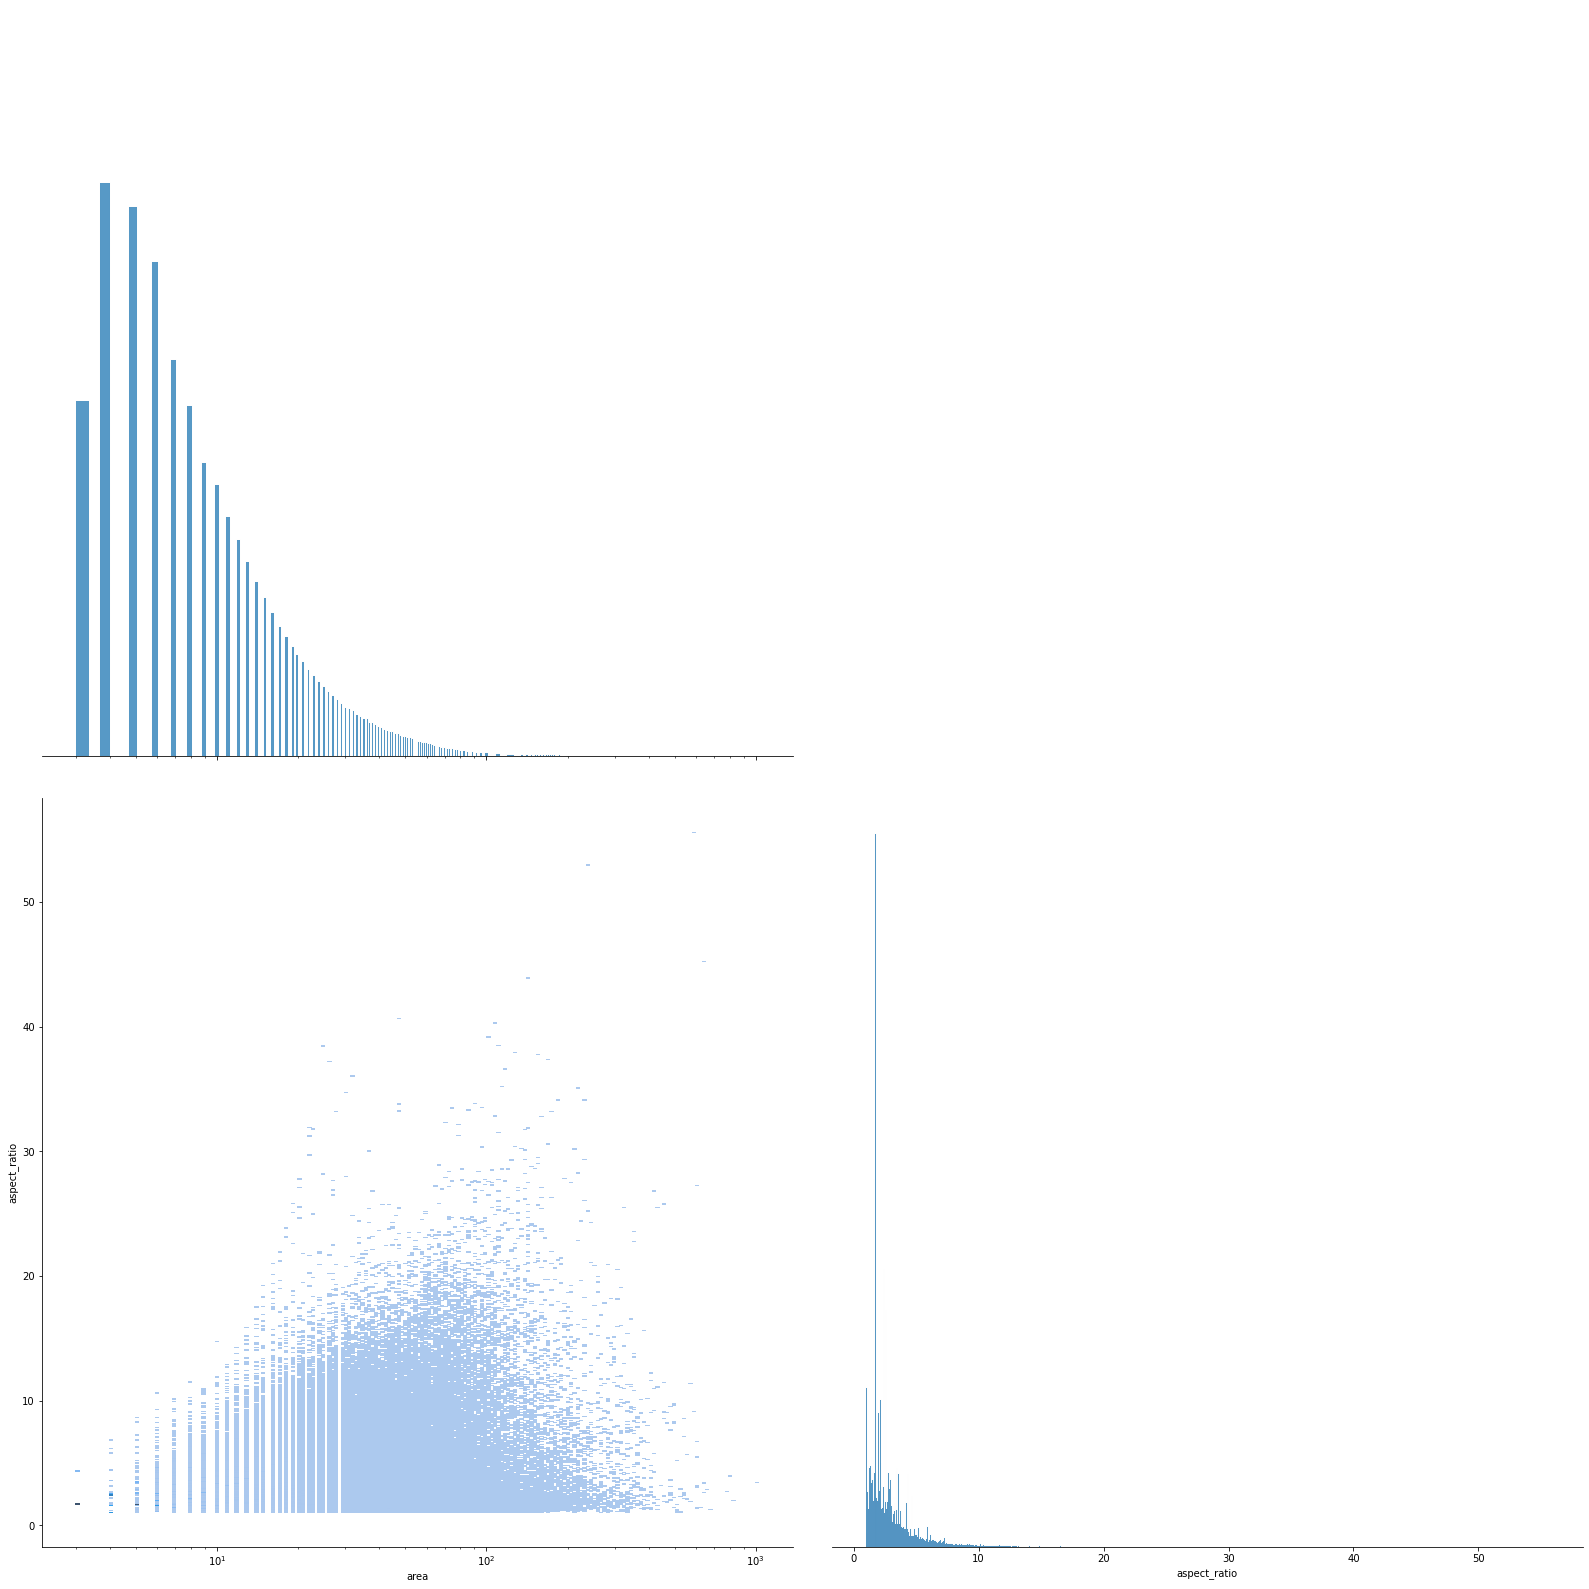

In [141]:
%%time
n = None
df = blobsdf.iloc[:n] if n is not None else blobsdf

pairgrid = sns.pairplot(
    df.replace([np.inf, -np.inf], np.nan).dropna(),
    vars=["area", "aspect_ratio"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(True, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 25, sz))

### Filter boring blobs

In [161]:
df = blobsdf

blobsdf_filtered = df[~((df.aspect_ratio < 10) & (df.area < 100))]
logger.debug(f"{df.shape=} {blobsdf_filtered.shape=}")

[2020-11-12::12:28:56.671] tomo2seg :: DEBUG :: {<ipython-input-161-f55f555ca449>:<module>:004}
df.shape=(797696, 24) blobsdf_filtered.shape=(131813, 24)



CPU times: user 852 ms, sys: 26.5 ms, total: 878 ms
Wall time: 881 ms


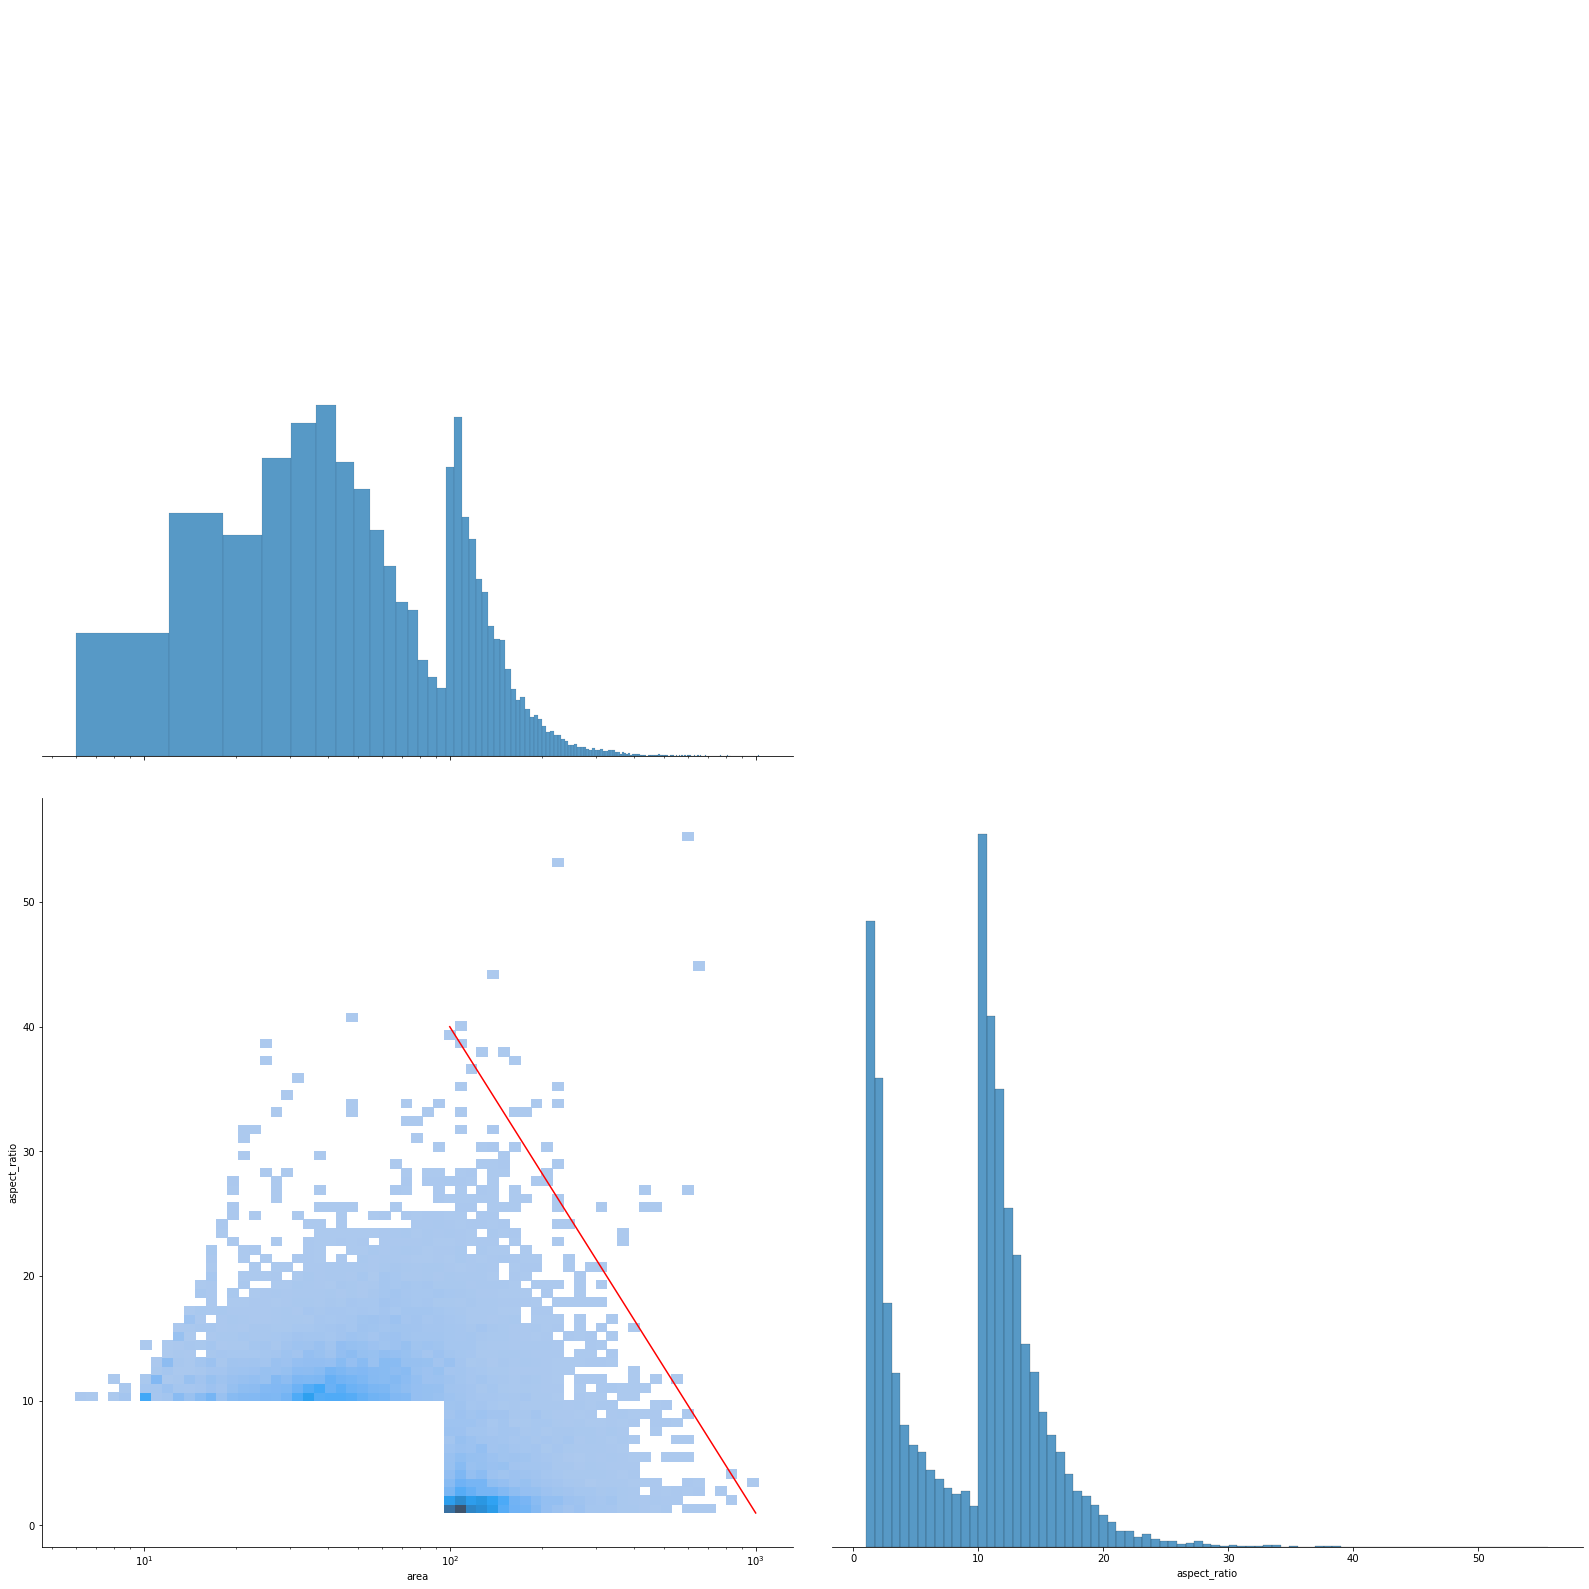

In [162]:
%%time
n = None
df = blobsdf_filtered
df = df.iloc[:n] if n is not None else df

line_points = (
    (100, 40),
    (1000, 1),
)

pairgrid = sns.pairplot(
    df.replace([np.inf, -np.inf], np.nan).dropna(),
    vars=["area", "aspect_ratio"],
    diag_kind="hist",
    diag_kws=dict(log_scale=False),
    kind="hist",
    plot_kws=dict(log_scale=(True, False), palette="inferno"),
    corner=True,
)
pairgrid.fig.set_size_inches(*(sz := 25, sz))

pairgrid.axes[1, 0].plot(*zip(*line_points), c='r')

In [168]:
m = (line_points[1][1] - line_points[0][1]) / (np.log10(line_points[1][0]) - np.log10(line_points[0][0]))
b = line_points[0][1] - m * np.log10(line_points[0][0])
m, b

(-39.0, 118.0)

<ipython-input-196-802c8ba340b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['criteria'] = df.aspect_ratio - m * np.log10(df.area) - b


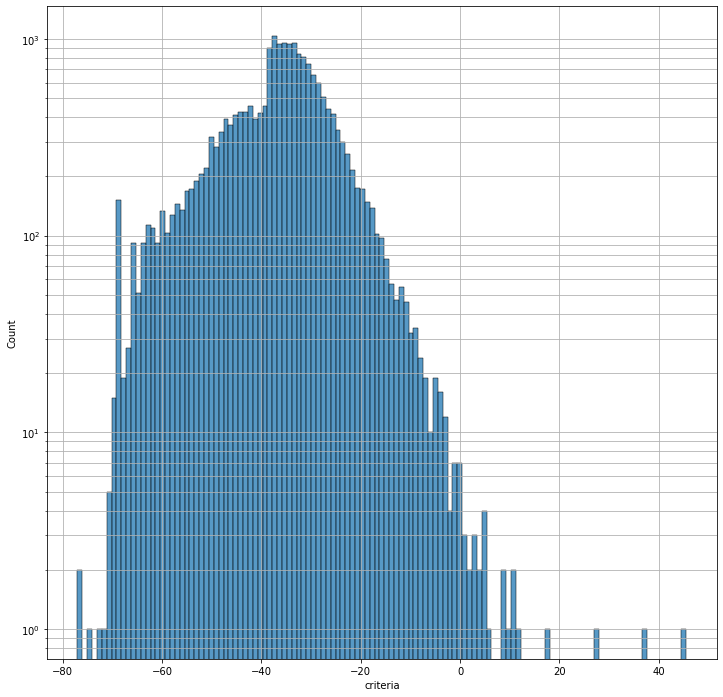

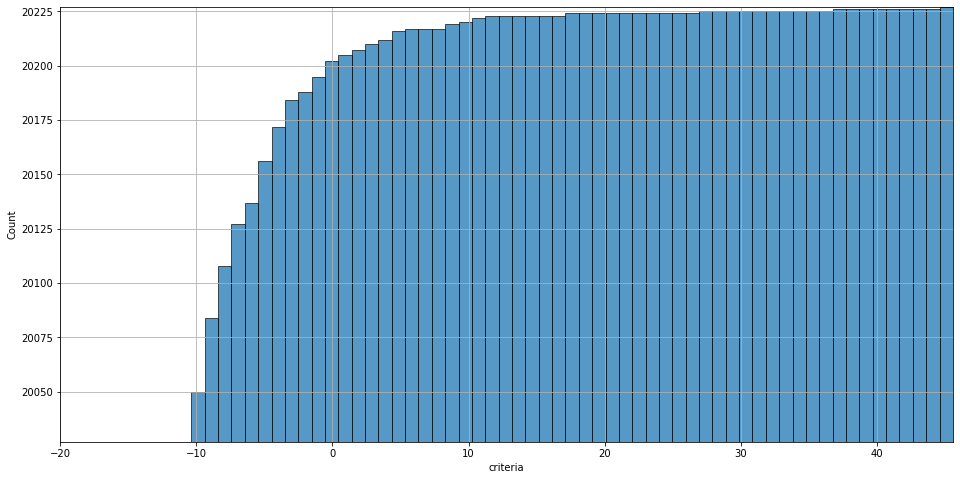

In [196]:
df = blobsdf_filtered

df['criteria'] = df.aspect_ratio - m * np.log10(df.area) - b
df = df.replace([np.inf, -np.inf], np.nan).dropna()

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sns.histplot(df, x='criteria', ax=ax, )
ax.set_yscale('log')
ax.grid(True, which='both')

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.histplot(df, x='criteria', ax=ax, cumulative=True)
# ax.set_yscale('log')
n_last = 200
ax.set_ylim(((n := df.shape[0]) - n_last, n))
ax.set_xlim(-20, df.criteria.max())
ax.grid(True, which='both')

In [197]:
bigcriteria = df[df.criteria >= 0]
bigcriteria.shape

(27, 24)

In [199]:
bigcriteria[["area", "z", "centroid-x", "centroid-y"]]

,area,z,centroid-x,centroid-y
index,,,,
29258,219,69,8,644
66207,574,154,552,615
66417,461,154,1264,479
66812,613,155,1265,464
118953,235,274,1285,751
126710,321,292,1219,966
165968,417,382,39,549
166416,358,383,39,552
181834,187,416,1154,307


In [203]:
df.iloc[62]

label                         2.000000
area                         36.000000
bbox-0                       47.000000
bbox-1                      811.000000
bbox-2                       51.000000
bbox-3                      834.000000
bbox_area                    92.000000
centroid-x                   48.000000
centroid-y                  820.000000
eccentricity                  0.997000
euler_number                  1.000000
extent                        0.391400
filled_area                  36.000000
inertia_tensor_eigvals-0     40.000000
inertia_tensor_eigvals-1      0.241800
local_centroid-0              1.639000
local_centroid-1              9.664000
major_axis_length            25.300000
minor_axis_length             1.967000
perimeter                    35.000000
solidity                      0.706000
z                             9.000000
aspect_ratio                 12.862227
criteria                    -44.441976
Name: 4189, dtype: float64

In [ ]:
label_imae[slice(label_image, [df.iloc[62].bbox-0, df.iloc[62].bbox-1, df.iloc[62].bbox-2, df.iloc[62].bbox-3]) == 62] = 0